# Molecular Descriptors, Fingerprints and similarity score analysis of 8-aminoquinoline (8-AQ) fluorescent probes

## Introduction

Code sources and inspriations from:

Jennifer Lin Data Science and Cheminformatics Blog:

https://github.com/jhylin/Data_in_life_blog/blob/main/posts/07_Molecular_similarities_in_COVID-19_antivirals/Mol_sim_covid.qmd

Machine Learning in Chemistry from Scratch YouTube video:

https://youtu.be/-oHqQBUyrQ0?si=_6_RKqIw2kvUNpA6

RDKit Documentation:

https://www.rdkit.org/docs/

Molecular fingerprints are moelcular descriptors that encode molecular features/fragments of a molecule in the form of a binary digit (0 or 1). For drug discovery, these features can include (but are not limited to) specific functional groups (aldehydes, ketones, amides, etc) or ring structures (benzene, pyridine, etc) present within the molecule. These fingerprints allow for the creation of a mathematical matrix that can be used to perform computations. Fingerprints are divided into 'bits' that indicate whether or not a specific descriptor is present within a molecule. A bit is defined to be "ON" or 1 if a certain fragment is found in a molecular structure. These include:

1) Extended Connectivity Fingerprinting (ECFP). These are circular, topological fingerprints designed for moelcular characterization, similarity searching, and structure-activity modeling.

2) MACCS Keys (Molecular ACCess System). These are 2D structure fingerprints that are used for the measure of molecular similarity. They encode the presence of 166 predefined structural features.

3) Morgan Fingerprint (Circular Fingerprint). Sometimes described as a reimplementation of the ECFP, these fingerprints utilize circular fingerprints to capture atom environments within a specified radius.

4) Pharmacophore Fingerprints. Creates fingerprints based on the presence or absence of pharmacophore features and distances in a single molecule or compound collection. 

5) Topological Torsion Fingerprint. These fingerprints seek to compliment the long range relationships captured in atom pair fingerprints by representing short-range information contained in the torsion angles of a molecule.

6) Atom Pairs Fingerprints. Atom pairs are "defined in terms of the atomic environments of, and shorest path separations between, all pairs of atoms in the topological representation of a chemical structure." ( Carhart et al. JCICS 25:64-73 (1985)). Distinct atom types are defined by tuples of atomic number, number of heavy atom neighbors, aromaticity and chirality. All unique triplets in a molecule are enumerated and stored in sparse count or bit vector format.

7) Avalon Fingerprints. These are substructure or similarity fingerprints that allow for faster substructure queries.

This project will focus on generating these various fingerprints for 8-AQ fluorescent probes using the RDKit package. This notebook will generate Morgan, MACCS keys, and Avalon fingerprints. I will also generate dice and cosine similarity scores and tanimoto coefficients from Morgan fingerprints for 8-AQs and their corresponding fluorescent probes using PQ as a reference. Finally, we will visualize the distribution of these scores, and discuss which methods are most effective for pharmacophore and substructure group searching.

In [1]:
#import standard python packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from rdkit import Chem
# RDKit drawing
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
# RDKit fingerprint generator
from rdkit.Chem import rdFingerprintGenerator
# RDKit functionality for basic data structures
from rdkit.Chem import DataStructs
# Settings to improve quality of structures
from rdkit.Chem import rdDepictor
# SVG = scalable vector graphics, set to false if wanting PNGs instead
IPythonConsole.ipython_useSVG = True
rdDepictor.SetPreferCoordGen(True)
# Add ability to add a molecule to a dataframe
from rdkit.Chem import PandasTools
#For molecular descriptors
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import SimilarityMaps
import io
from PIL import Image
# mols2grid library provides convenient way to display molecules in a grid
import mols2grid
from rdkit import RDLogger
from rdkit.Chem import AllChem

In [2]:
#construct dataframe with 8-aminoquinoline (8-AQ) and 8-AQ fluorescent probe SMILES and IC50s in P. falciparum

cmpd_dict = {'Compound':['Primaquine', 'PQCP', 'Tafenoquine', 'TQCP'], 'SMILES': ['COc2cc(NC(C)CCCN)c1ncccc1c2', 
                            'COc4cc(NC(C)CCCNC(=O)CCCc1cc(=O)oc2cc(O)ccc12)c3ncccc3c4', 
                            "COc3cc(C)c2c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)CCCN)c2n3", 
                            "COc5cc(C)c4c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)CCCNC(=O)CCCc2cc(=O)oc3cc(O)ccc23)c4n5"] 
                                                           , "3D7_IC50 (uM)":[5.77, 10.5, 3.59, 2.19]}

df = pd.DataFrame(cmpd_dict)

df

,Compound,SMILES,3D7_IC50 (uM)
0,Primaquine,COc2cc(NC(C)CCCN)c1ncccc1c2,5.77
1,PQCP,COc4cc(NC(C)CCCNC(=O)CCCc1cc(=O)oc2cc(O)ccc12)...,10.50
2,Tafenoquine,COc3cc(C)c2c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)...,3.59
3,TQCP,COc5cc(C)c4c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)...,2.19


In [3]:
#define cmpds variable to create object for molecules
cmpds = df['SMILES'].apply(Chem.MolFromSmiles).tolist()
cmpds

In [4]:
#display molecules in grid format
mols2grid.display(cmpds)

MolGridWidget()

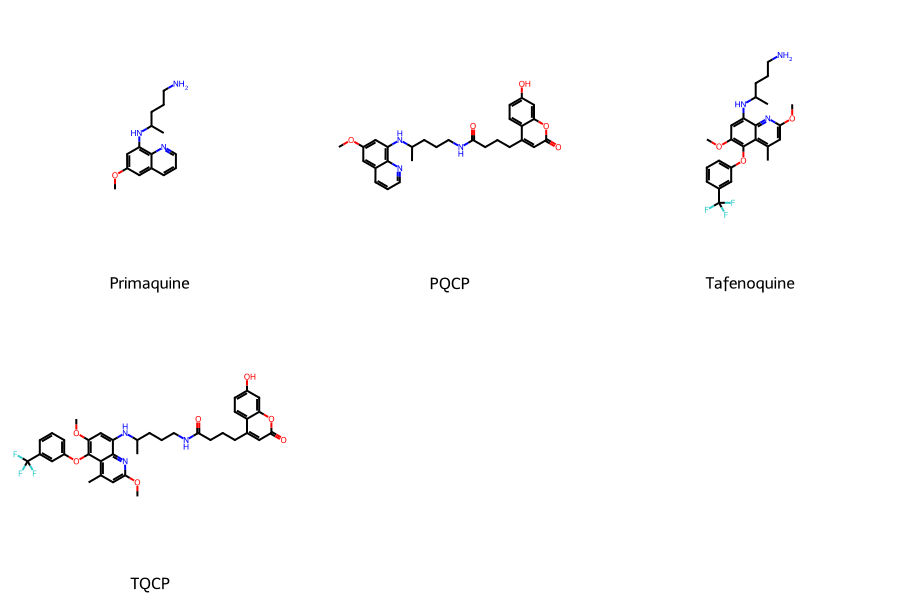

In [5]:
#Drawing molecules in a grid and labeling them

Draw.MolsToGridImage(cmpds, molsPerRow = 3, 
                     legends = ("Primaquine", "PQCP", "Tafenoquine", "TQCP"), 
                     subImgSize=(300, 300), 
                     useSVG = True
                    )

### Assigning each molecule to a variable

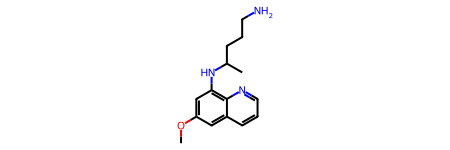

In [6]:
#Primaquine
PQ = Chem.MolFromSmiles("COc2cc(NC(C)CCCN)c1ncccc1c2")
PQ

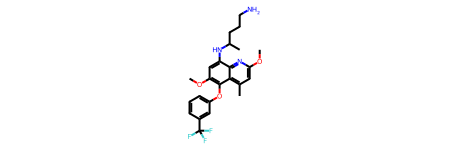

In [7]:
#Tafenoquine
TQ = Chem.MolFromSmiles("COc3cc(C)c2c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)CCCN)c2n3")
TQ

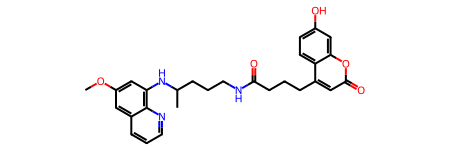

In [8]:
#Primaquine-Coumarin Probe
PQCP = Chem.MolFromSmiles('COc4cc(NC(C)CCCNC(=O)CCCc1cc(=O)oc2cc(O)ccc12)c3ncccc3c4')
PQCP

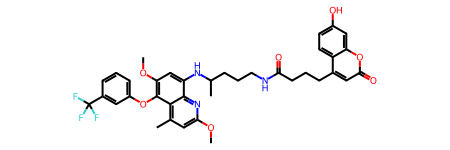

In [9]:
#Tafenoquine-Coumarin Probe
TQCP = Chem.MolFromSmiles("COc5cc(C)c4c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)CCCNC(=O)CCCc2cc(=O)oc3cc(O)ccc23)c4n5")
TQCP

,Compound,SMILES,3D7_IC50 (uM),Molecular_structure
0,Primaquine,COc2cc(NC(C)CCCN)c1ncccc1c2,5.77,
1,PQCP,COc4cc(NC(C)CCCNC(=O)CCCc1cc(=O)oc2cc(O)ccc12)...,10.50,
2,Tafenoquine,COc3cc(C)c2c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)...,3.59,
3,TQCP,COc5cc(C)c4c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)...,2.19,

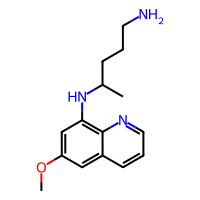
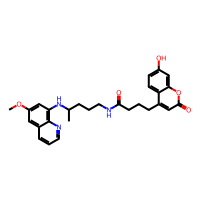
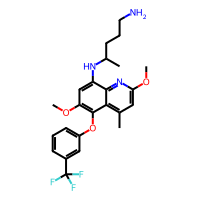
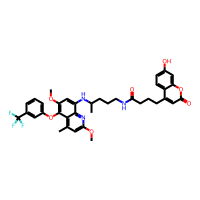

In [10]:
#generating molecular images from smiles and integrating into df

#adding molecular structure column to df
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='SMILES', molCol='Molecular_structure', includeFingerprints=False)

#display molecular structure instead of HTML code
PandasTools.RenderImagesInAllDataFrames(images=True)

df.head()

## Generating molecular descriptors using RDKit

RDKit can be used to calculate molecular properties of molecules that affect their Absorption, Distribution, Metabolism, and Excretion (ADME). Some properties of note include:

Molecular Weight: The sum of the atomic weights of every atom in the molecule. Can affect absorption and distribution of a drug (to a degree). 

LogP: The water/octanol partion coefficient of a compound; often used as a measure of lipophilicity of a drug. Can help determine ADME kinetics and properties of a compound.

Polar Surface Area (PSA): The combined surface area of nitrogen and oxygen molecules, and the hydrogens bonded to them. Studies suggest this is a useful metric to determining blood-brain barrier penetration, intenstinal absorption, and improving cellular potency.

H-bond acceptors: these are (usually) electronegative atoms that have a lone pair of electrons capable of participating in a hydrogen bond. These hydrogen bonds are a type of dipole-dipole interaction and are not covalent or ionic bonds (which require sharing electron pairs between atoms).

H-bond donors: These are electronegative atoms such as N, O, F, etc, that are covalently bonded to a hydrogen atom. This bond results in a dipole moment that pulls electronegativity away from the hydrogen, increasing it's positive character and making it susceptible to H-bonding with acceptors.

Both donors and acceptors have importance in drug discovery, as they influence ADME properties as well as affecting how well drugs bind at the target active site. 

All of these properties are noted in Lipinski's "rule of 5", where an orally bioavailable compounds should follow these rules:

>Have H-Bond acceptors =< 10,

>Have H-Bond Donors =< 5,

>Have a molecular weight (in Daltons) =< 500,

>Have a calculated LogP < 5

Variants of this rule incorporate PSA as well, suggesting that PSA =< 140 A<sup>2</sup> for a drug to be more orally active.

In [11]:
#what are some of the molecular properties of the 8-AQ antimalarials and their probes?

def mol_properties(smiles):
    MW = []
    logp = []
    tpsa = []
    H_acceptors = []
    H_donors = []
    
    mols = [Chem.MolFromSmiles(x) for x in smiles]
    for mol in mols:
        #calculate molecular weight
        mwt = Descriptors.MolWt(mol)
        MW.append(mwt)
        
        #calculate logp 
        log_p = Descriptors.MolLogP(mol)
        logp.append(log_p)
        
        #calculate polar surface area value 
        psav = Descriptors.TPSA(mol)
        tpsa.append(psav)
        
        #calculate H-bond acceptors
        hacc = Descriptors.NumHAcceptors(mol)
        H_acceptors.append(hacc)
        
        #calc H-bond donors
        hdon = Descriptors.NumHDonors(mol)
        H_donors.append(hdon)
        
    return MW, logp, tpsa, H_acceptors, H_donors

,Compound,SMILES,3D7_IC50 (uM),Molecular_structure,Molecular Weight,LogP,Polar Surface Area,H_bond_acc,H_bond_donors
0,Primaquine,COc2cc(NC(C)CCCN)c1ncccc1c2,5.77,,259.353,2.78270,60.17,4,2
1,PQCP,COc4cc(NC(C)CCCNC(=O)CCCc1cc(=O)oc2cc(O)ccc12)...,10.50,,489.572,4.77510,113.69,7,3
2,Tafenoquine,COc3cc(C)c2c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)...,3.59,,463.500,5.91082,78.63,6,2
3,TQCP,COc5cc(C)c4c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)...,2.19,,693.719,7.90322,132.15,9,3

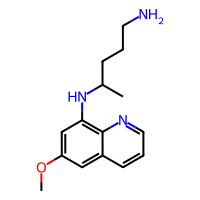
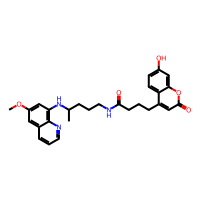
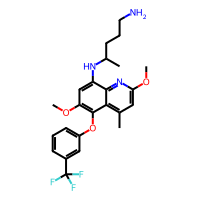
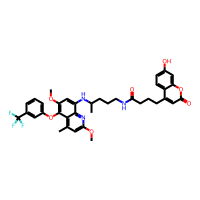

In [12]:
#use function to append descriptors to df

MW, logp, tpsa, H_acceptors, H_donors = mol_properties(df['SMILES'])
df['Molecular Weight'] = MW
df['LogP'] = logp
df['Polar Surface Area'] =  tpsa
df['H_bond_acc'] = H_acceptors
df['H_bond_donors'] = H_donors

df.head()

In [13]:
#finding all descriptors generated by rdkit 

#place molecules into list
mol_list = [PQ, PQCP, TQ, TQCP]

#generate descriptors
descr = [Descriptors.CalcMolDescriptors(mol) for mol in mol_list]

# Generate DataFrame and set the molecule names as the index
df_descr = pd.DataFrame(descr, index=df['Compound']) 

#display molecular structure instead of HTML code
PandasTools.RenderImagesInAllDataFrames(images=True)

df_descr.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
Compound,,,,,,,,,,,,,,,,,,,,,
Primaquine,5.546261,5.546261,0.361909,0.361909,0.837129,259.353,238.185,259.168462,102,0,...,0,0,0,0,0,0,0,0,0,0
PQCP,12.298928,12.298928,0.010632,-0.464809,0.205291,489.572,458.324,489.226371,188,0,...,0,0,0,0,0,0,0,0,1,0
Tafenoquine,13.195201,13.195201,0.038580,-4.482334,0.410730,463.500,435.276,463.208276,178,0,...,0,0,0,0,0,0,0,0,0,0
TQCP,13.398982,13.398982,0.001611,-4.532760,0.078445,693.719,655.415,693.266185,264,0,...,0,0,0,0,0,0,0,0,1,0


In [14]:
#code to merge df to df_descr
df_ = df.merge(df_descr, how='left', on='Compound')
df_.isna().any().all()

False

In [15]:
#how many columns only have 0 values for compounds?

col_with_zero = df_.columns[(df_ == 0).all()]
print(col_with_zero)

Index(['NumRadicalElectrons', 'PEOE_VSA13', 'PEOE_VSA5', 'SMR_VSA2',
       'SMR_VSA8', 'SlogP_VSA12', 'SlogP_VSA7', 'SlogP_VSA9', 'EState_VSA11',
       'VSA_EState10', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles',
       'NumAliphaticRings', 'NumSaturatedCarbocycles',
       'NumSaturatedHeterocycles', 'NumSaturatedRings', 'fr_Al_COO',
       'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_NH',
       'fr_COO', 'fr_COO2', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_N_O',
       'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH',
       'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_allylic_oxid', 'fr_amidine',
       'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo',
       'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_furan',
       'fr_guanido', 'fr_hdrzine', 'fr_hdrzone', 'fr_imidazole', 'fr_imide',
       'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss',
       'fr_lactam', 'fr_lactone', 'fr_morpholine', 'fr_nitril

,Compound,SMILES,3D7_IC50 (uM),Molecular_structure,Molecular Weight,LogP,Polar Surface Area,H_bond_acc,H_bond_donors,MaxAbsEStateIndex,...,fr_aryl_methyl,fr_benzene,fr_bicyclic,fr_ether,fr_halogen,fr_methoxy,fr_phenol,fr_phenol_noOrthoHbond,fr_pyridine,fr_unbrch_alkane
0,Primaquine,COc2cc(NC(C)CCCN)c1ncccc1c2,5.77,,259.353,2.78270,60.17,4,2,5.546261,...,0,1,1,1,0,1,0,0,1,0
1,PQCP,COc4cc(NC(C)CCCNC(=O)CCCc1cc(=O)oc2cc(O)ccc12)...,10.50,,489.572,4.77510,113.69,7,3,12.298928,...,1,2,2,1,0,1,1,1,1,1
2,Tafenoquine,COc3cc(C)c2c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)...,3.59,,463.500,5.91082,78.63,6,2,13.195201,...,1,2,1,3,3,2,0,0,1,0
3,TQCP,COc5cc(C)c4c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)...,2.19,,693.719,7.90322,132.15,9,3,13.398982,...,2,3,2,3,3,2,1,1,1,1

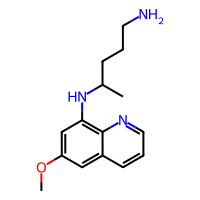
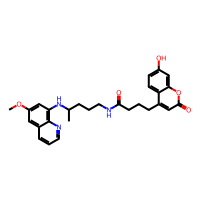
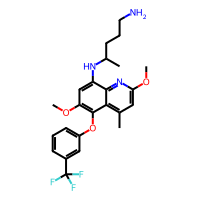
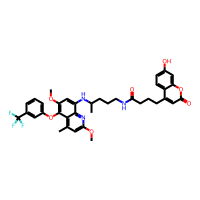

In [16]:
#dropping col_with_zero from df

df_.drop(col_with_zero, axis=1, inplace=True)
df_

In [17]:
#to ensure ADME descriptors (logp, psa, etc) aren't already present in the CalcMolDescriptors method
duplicate_columns = df_.columns[df_.columns.duplicated()]
print(duplicate_columns)

Index([], dtype='object')


In [18]:
#saving df_ for future projects and analysis

# df_.to_csv('Probedata.xlsx', index=False)

## Generating Morgan-Circular Fingerprints

In [19]:
#generate Morgan fingerprints and onbits for PQ
Morganbits ={}
mf_PQ = AllChem.GetMorganFingerprintAsBitVect(PQ, 2, nBits=512, bitInfo=Morganbits)
print(np.array(mf_PQ))

[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 

In [20]:
#Index and number of onbits
#index of on bits
print("Index of On bits:", tuple(mf_PQ.GetOnBits()))

#number of on bits
print("Number of On bits:", len(mf_PQ.GetOnBits()))

Index of On bits: (0, 1, 19, 33, 63, 64, 80, 103, 128, 130, 147, 175, 178, 183, 188, 194, 200, 214, 227, 269, 283, 304, 319, 322, 323, 329, 330, 337, 340, 356, 363, 375, 378, 380, 403, 422, 428, 441, 448, 469, 475, 482, 493)
Number of On bits: 43


In [21]:
#generate Morgan fingerprints and onbits for PQ
MorganbitsTQ ={}
mf_TQ = AllChem.GetMorganFingerprintAsBitVect(TQ, 2, nBits=512, bitInfo=MorganbitsTQ)
print(np.array(mf_TQ))

[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 0 0 0 0 0 0 0 

In [22]:
#Index and number of onbits
#index of on bits
print("Index of On bits:", tuple(mf_TQ.GetOnBits()))

#number of on bits
print("Number of On bits:", len(mf_TQ.GetOnBits()))

Index of On bits: (0, 1, 15, 33, 34, 50, 64, 80, 81, 103, 114, 120, 128, 130, 141, 147, 149, 170, 175, 178, 183, 186, 188, 200, 214, 227, 236, 249, 276, 283, 290, 297, 304, 319, 322, 329, 333, 337, 340, 346, 356, 363, 367, 375, 378, 392, 393, 422, 429, 434, 448, 463, 469, 470, 471, 481, 482, 485, 493, 498)
Number of On bits: 60


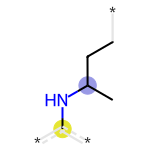

In [23]:
#How can i see what feature turns a bit 'on' in the notebook?

Draw.DrawMorganBit(PQ, 175, Morganbits) #seeing what feature 175 describes in PQ

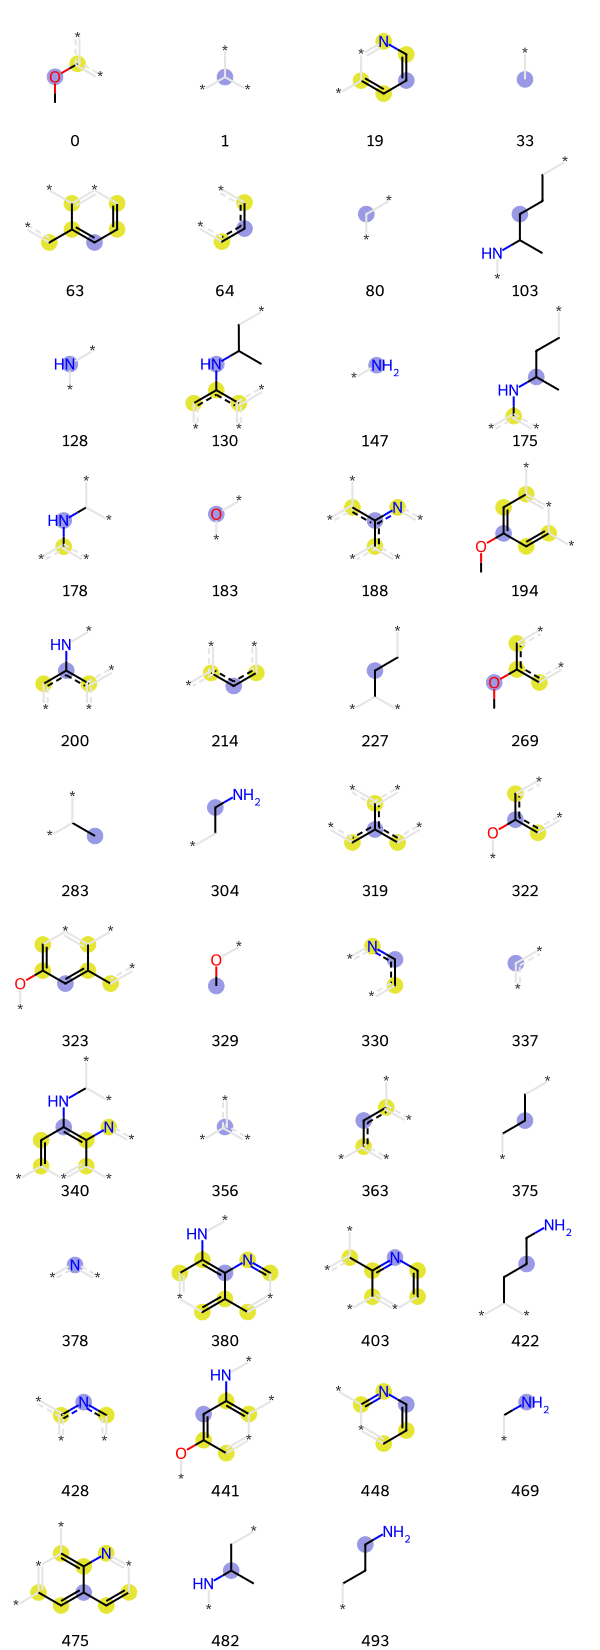

In [24]:
#What if I wanted to render all the features responsible for making ON bits?

all_frag = [(PQ, x, Morganbits) for x in mf_PQ.GetOnBits()]
Draw.DrawMorganBits(all_frag[:], molsPerRow=4, legends=[str(x) for x in mf_PQ.GetOnBits()][:])

#### Note: 
The numbers above represent the INDEX value of the bit, and not the actual value within the package itself. The value within the package can be found by subtracting 1 from the index value listed.

## Generating MACCS Keys fingerprints

MACCS finger prints will be generated based on the 'df' dataframe. Fingerprints will be generated based on upon the molecular graphs instead of the SMILES.

In [25]:
#generating Molecular Access System keys

#load MACCS key package
from rdkit.Chem import MACCSkeys
#define variable for MACCS key generation for Primaquine
Mkey_PQ = MACCSkeys.GenMACCSKeys(df.Molecular_structure[0])

#use numpy array to see on and off bits for PQ
print(np.array(Mkey_PQ))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 0 0
 1 0 1 0 1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 1 0 1
 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0]


In [26]:
np.array(Mkey_PQ).shape

(167,)

In [27]:
#how many bits are on in PQ?

#index of on bits
print("Index of On bits:", tuple(Mkey_PQ.GetOnBits()))

#number of on bits
print("Number of On bits:", len(Mkey_PQ.GetOnBits()))

Index of On bits: (65, 79, 82, 84, 90, 91, 93, 97, 98, 100, 101, 104, 105, 108, 111, 113, 115, 116, 118, 121, 125, 126, 127, 131, 133, 135, 137, 142, 143, 145, 147, 149, 151, 152, 153, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165)
Number of On bits: 45


In [28]:
#define a function that will take a molecular structure from the dataframe and return the index and number of on bits

def MACCSKey_bitgen(structure):
    Key = MACCSkeys.GenMACCSKeys(structure)
    Index = tuple(Key.GetOnBits())
    Number = len(Key.GetOnBits())
    
    return print("Index of On bits:", Index), print("Number of On bits:", Number)

In [29]:
#MACCSKey generation for PQCP

MACCSKey_bitgen(df.Molecular_structure[1])

Index of On bits: (57, 65, 79, 82, 89, 90, 91, 92, 93, 97, 98, 100, 101, 104, 105, 108, 110, 111, 113, 115, 116, 117, 118, 120, 121, 123, 125, 126, 127, 128, 129, 131, 132, 133, 135, 136, 137, 139, 140, 142, 143, 145, 146, 147, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165)
Number of On bits: 60


(None, None)

In [30]:
#Keys for TQ and TQCP

MACCSKey_bitgen(TQ)

Index of On bits: (42, 65, 72, 79, 82, 84, 90, 91, 92, 93, 97, 98, 100, 101, 104, 105, 106, 107, 108, 110, 111, 112, 113, 115, 116, 117, 118, 121, 125, 126, 127, 131, 133, 134, 135, 137, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165)
Number of On bits: 59


(None, None)

In [31]:
MACCSKey_bitgen(TQCP)

Index of On bits: (42, 57, 65, 72, 79, 82, 89, 90, 91, 92, 93, 97, 98, 100, 101, 104, 105, 106, 107, 108, 110, 111, 112, 113, 115, 116, 117, 118, 120, 121, 123, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165)
Number of On bits: 69


(None, None)

## Generating Avalon Fingerprints

In [32]:
from rdkit.Avalon import pyAvalonTools

Av_PQ = pyAvalonTools.GetAvalonFP(PQ, nBits=512)
print(np.array(Av_PQ))

[1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1
 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 1 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 1
 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0
 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0
 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 1 0 0 0 1 

In [33]:
#index of on bits
print("Index of On bits:", tuple(Av_PQ.GetOnBits()))

#number of on bits
print("Number of On bits:", len(Av_PQ.GetOnBits()))

Index of On bits: (0, 7, 9, 13, 15, 16, 19, 23, 26, 34, 36, 38, 41, 49, 57, 59, 60, 62, 67, 71, 74, 80, 81, 84, 86, 104, 110, 112, 116, 117, 125, 132, 138, 139, 145, 153, 157, 179, 181, 182, 186, 189, 193, 194, 199, 203, 205, 214, 220, 222, 244, 251, 253, 262, 266, 270, 274, 279, 281, 284, 288, 291, 292, 293, 295, 298, 304, 305, 312, 315, 319, 322, 323, 324, 337, 343, 345, 350, 351, 354, 359, 364, 365, 370, 371, 374, 375, 383, 389, 400, 407, 417, 418, 425, 436, 439, 440, 442, 451, 454, 455, 464, 471, 478, 486, 488, 492, 495, 502)
Number of On bits: 109


### What if we wanted to generate morgan fingerprints for multiple molecules and place them into a dataframe?

Let's define a function that will generate different fingerprints for each compound, then place them into our dataframe. This will allow us to calculate various similarity scores based on the different fingerprint types.

In [34]:
#create function that generates morgan fingerprints based on molecules in a list or dataframe

def generate_morganfp(mol_list, radius=2, nBits=2048):
    
    Morgan_fp = []
    
    for mol in mol_list:
        if mol is not None:
            bitInfo={}
            m_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, bitInfo=bitInfo)
            Morgan_fp.append(m_fp)
        
    return Morgan_fp

In [35]:
Morgan_fp = generate_morganfp(df_['Molecular_structure'])

,Compound,SMILES,3D7_IC50 (uM),Molecular_structure,Molecular Weight,LogP,Polar Surface Area,H_bond_acc,H_bond_donors,MaxAbsEStateIndex,...,fr_benzene,fr_bicyclic,fr_ether,fr_halogen,fr_methoxy,fr_phenol,fr_phenol_noOrthoHbond,fr_pyridine,fr_unbrch_alkane,Morgan_fp
0,Primaquine,COc2cc(NC(C)CCCN)c1ncccc1c2,5.77,,259.353,2.78270,60.17,4,2,5.546261,...,1,1,1,0,1,0,0,1,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,PQCP,COc4cc(NC(C)CCCNC(=O)CCCc1cc(=O)oc2cc(O)ccc12)...,10.50,,489.572,4.77510,113.69,7,3,12.298928,...,2,2,1,0,1,1,1,1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,Tafenoquine,COc3cc(C)c2c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)...,3.59,,463.500,5.91082,78.63,6,2,13.195201,...,2,1,3,3,2,0,0,1,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,TQCP,COc5cc(C)c4c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)...,2.19,,693.719,7.90322,132.15,9,3,13.398982,...,3,2,3,3,2,1,1,1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."

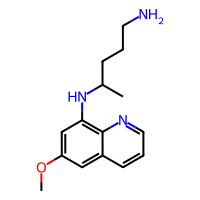
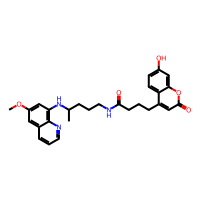
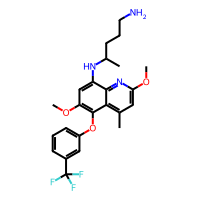
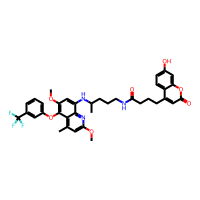

In [36]:
df_['Morgan_fp'] = Morgan_fp

df_.head()

In [37]:
#check to ensure fingerprint wasn't duplicated in dataframe
df_['Morgan_fp'][0] == df_['Morgan_fp'][3]

False

Let's also do this for MACCSKeys and Avalon fingerprints

In [38]:
#MACCSKey fingerprint generator
def generate_MACCS(mol_list):
    MACCS = []
    
    for mol in mol_list:
        maccs_fp = MACCSkeys.GenMACCSKeys(mol)
        MACCS.append(maccs_fp)
        
    return MACCS

In [39]:
MACCS_fp = generate_MACCS(df_['Molecular_structure'])

,Compound,SMILES,3D7_IC50 (uM),Molecular_structure,Molecular Weight,LogP,Polar Surface Area,H_bond_acc,H_bond_donors,MaxAbsEStateIndex,...,fr_bicyclic,fr_ether,fr_halogen,fr_methoxy,fr_phenol,fr_phenol_noOrthoHbond,fr_pyridine,fr_unbrch_alkane,Morgan_fp,MACCS_fp
0,Primaquine,COc2cc(NC(C)CCCN)c1ncccc1c2,5.77,,259.353,2.78270,60.17,4,2,5.546261,...,1,1,0,1,0,0,1,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,PQCP,COc4cc(NC(C)CCCNC(=O)CCCc1cc(=O)oc2cc(O)ccc12)...,10.50,,489.572,4.77510,113.69,7,3,12.298928,...,2,1,0,1,1,1,1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Tafenoquine,COc3cc(C)c2c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)...,3.59,,463.500,5.91082,78.63,6,2,13.195201,...,1,3,3,2,0,0,1,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,TQCP,COc5cc(C)c4c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)...,2.19,,693.719,7.90322,132.15,9,3,13.398982,...,2,3,3,2,1,1,1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

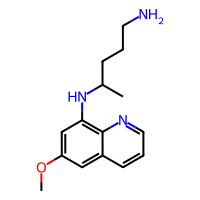
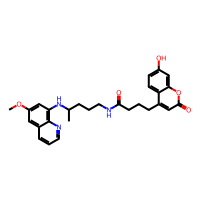
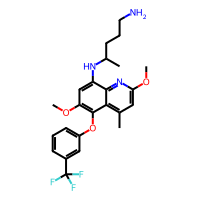
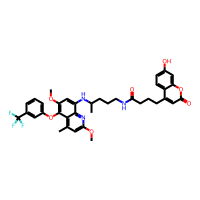

In [40]:
df_['MACCS_fp'] = MACCS_fp
df_.head()

In [41]:
df_['MACCS_fp'][0] == df_['MACCS_fp'][1]

False

In [42]:
#avalon fingerprint generator
def generate_avalon_fp(mol_list):
    
    Avalon = []
    
    for mol in mol_list:
        Av = pyAvalonTools.GetAvalonFP(mol, nBits=512)
        Avalon.append(Av)
        
    return Avalon

,Compound,SMILES,3D7_IC50 (uM),Molecular_structure,Molecular Weight,LogP,Polar Surface Area,H_bond_acc,H_bond_donors,MaxAbsEStateIndex,...,fr_ether,fr_halogen,fr_methoxy,fr_phenol,fr_phenol_noOrthoHbond,fr_pyridine,fr_unbrch_alkane,Morgan_fp,MACCS_fp,Avalon_fp
0,Primaquine,COc2cc(NC(C)CCCN)c1ncccc1c2,5.77,,259.353,2.78270,60.17,4,2,5.546261,...,1,0,1,0,0,1,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ..."
1,PQCP,COc4cc(NC(C)CCCNC(=O)CCCc1cc(=O)oc2cc(O)ccc12)...,10.50,,489.572,4.77510,113.69,7,3,12.298928,...,1,0,1,1,1,1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, ..."
2,Tafenoquine,COc3cc(C)c2c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)...,3.59,,463.500,5.91082,78.63,6,2,13.195201,...,3,3,2,0,0,1,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ..."
3,TQCP,COc5cc(C)c4c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)...,2.19,,693.719,7.90322,132.15,9,3,13.398982,...,3,3,2,1,1,1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, ..."

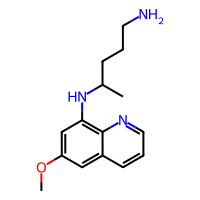
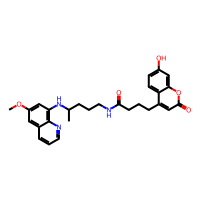
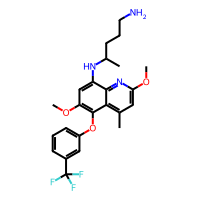
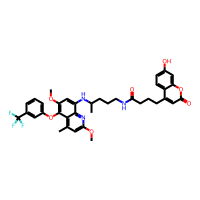

In [43]:
Avalon_fp = generate_avalon_fp(df_['Molecular_structure'])
df_['Avalon_fp'] = Avalon_fp
df_.head()

In [44]:
df_['Avalon_fp'][0] == df_['Avalon_fp'][1]

False

We now have the appropriate Morgan, MACCSKey, and Avalon fingerprints for each structure in the dataframe. Now, we can calculate tanimoto coefficients using PQ as a reference point and compare the different types of similarity scores

## Molecular Similarity : Tanimoto coefficients (manual calculations)

In [45]:
#get morgan FP of PQ and PQCP
#store onbits in dictionary
bit_PQ = {}
bit_PQCP = {}

PQ_FP = AllChem.GetMorganFingerprintAsBitVect(PQ, 2, nBits=2048, bitInfo=bit_PQ)
PQCP_FP = AllChem.GetMorganFingerprintAsBitVect(PQCP, 2, nBits=2048, bitInfo=bit_PQCP)

In [46]:
print("PQ:", sorted(set(PQ_FP.GetOnBits())))
print('PQCP:', sorted(set(PQCP_FP.GetOnBits())))

PQ: [1, 80, 283, 322, 378, 441, 448, 475, 615, 687, 690, 695, 739, 781, 835, 841, 875, 892, 981, 1043, 1057, 1087, 1088, 1152, 1171, 1218, 1224, 1364, 1380, 1452, 1517, 1536, 1666, 1724, 1750, 1840, 1855, 1866, 1873, 1911, 1939, 1958, 2018]
PQCP: [1, 14, 41, 80, 93, 197, 283, 314, 322, 378, 381, 406, 441, 448, 459, 472, 475, 597, 615, 650, 656, 667, 687, 690, 695, 708, 739, 745, 781, 807, 835, 841, 852, 875, 892, 1043, 1057, 1087, 1088, 1141, 1152, 1218, 1224, 1243, 1313, 1349, 1357, 1364, 1380, 1452, 1527, 1536, 1564, 1589, 1602, 1604, 1666, 1718, 1724, 1733, 1741, 1750, 1808, 1827, 1855, 1866, 1873, 1876, 1911, 1917, 1939, 2018]


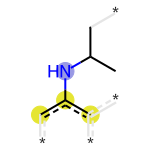

In [47]:
#onBit for 1666 in PQ and PQCP should be the same
Draw.DrawMorganBit(PQ, 1666, bit_PQ)

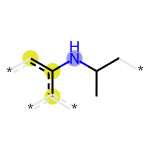

In [48]:
Draw.DrawMorganBit(PQCP, 1666, bit_PQCP)

In [49]:
#onbits for PQ and PQCP

cmpd_inter = set(PQ_FP.GetOnBits()) & set(PQCP_FP.GetOnBits())
print('Intersection of PQ and PQCP:', cmpd_inter)
print("Number of total intersecting bits:", len(cmpd_inter))

Intersection of PQ and PQCP: {1152, 1, 1666, 1536, 781, 1043, 1939, 283, 1057, 1452, 687, 690, 695, 441, 1724, 1087, 448, 1088, 322, 835, 1218, 1855, 1224, 841, 1866, 80, 1873, 1364, 1750, 475, 2018, 739, 1380, 615, 875, 1911, 378, 892}
Number of total intersecting bits: 38


In [50]:
Union = set(PQ_FP.GetOnBits()) | set(PQCP_FP.GetOnBits())
print('Union:', Union)
print('Union bit total:', len(Union))

#Tanimoto coefficient is the number of ON bits in the intersection of two sets divided by their Union
print("Tanimoto coefficient estimate:", len(cmpd_inter)/len(Union))

Union: {1536, 1, 781, 14, 1808, 1043, 283, 1564, 1057, 1313, 1827, 807, 41, 1840, 1589, 314, 1087, 1088, 1855, 322, 835, 1602, 1349, 1604, 841, 1866, 1357, 80, 1873, 1364, 852, 597, 1876, 93, 1380, 615, 875, 1141, 1911, 378, 892, 1917, 381, 1152, 1666, 650, 656, 1171, 1939, 406, 667, 1958, 1452, 687, 690, 1718, 695, 441, 1724, 448, 1218, 708, 197, 1733, 1224, 459, 1741, 981, 1750, 472, 475, 1243, 2018, 739, 745, 1517, 1527}
Union bit total: 77
Tanimoto coefficient estimate: 0.4935064935064935


### Calculating Tanimoto coefficient using RDKit

In [51]:
DataStructs.FingerprintSimilarity(PQ_FP, PQCP_FP, metric=DataStructs.TanimotoSimilarity)

0.4935064935064935

The calculation from RDKit matches our formulaic calculation based on unions and intersections of onBits for PQ and PQCP. What is the coefficient for TQ and TQCP? PQ and TQ?

In [52]:
#let's define a function that will generate fingerprints and calculate the tanimoto coefficient all at once

def Tanimoto_calc(mol, mol2):
    
    #create empty dict for molecule bit info
    bits_mol = {}
    bits_mol2 = {}
    
    #generate fingerprints for molecules
    mol_FP = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048, bitInfo=bits_mol)
    mol2_FP = AllChem.GetMorganFingerprintAsBitVect(mol2, 2, nBits=2048, bitInfo=bits_mol2)
    
    #calculate tanimoto coefficient
    coeff = DataStructs.FingerprintSimilarity(mol_FP, mol2_FP, metric=DataStructs.TanimotoSimilarity)
    
    return coeff

In [53]:
Tanimoto_calc(TQ, TQCP)

0.59375

In [54]:
Tanimoto_calc(PQ, TQ)

0.4189189189189189

In [55]:
#comparing the molecule to itself should give a value of 1
Tanimoto_calc(PQ, PQ)

1.0

In [56]:
#calculation based on df fingerprint
T_coeff_PQTQ = DataStructs.FingerprintSimilarity(df_['Morgan_fp'][0], df_['Morgan_fp'][2], 
                                                         metric=DataStructs.TanimotoSimilarity)

print(T_coeff_PQTQ)

0.4189189189189189


,Compound,SMILES,3D7_IC50 (uM),Molecular_structure,Molecular Weight,LogP,Polar Surface Area,H_bond_acc,H_bond_donors,MaxAbsEStateIndex,...,fr_halogen,fr_methoxy,fr_phenol,fr_phenol_noOrthoHbond,fr_pyridine,fr_unbrch_alkane,Morgan_fp,MACCS_fp,Avalon_fp,Tanimoto_Morgan_PQref
0,Primaquine,COc2cc(NC(C)CCCN)c1ncccc1c2,5.77,,259.353,2.78270,60.17,4,2,5.546261,...,0,1,0,0,1,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ...",1.000000
1,PQCP,COc4cc(NC(C)CCCNC(=O)CCCc1cc(=O)oc2cc(O)ccc12)...,10.50,,489.572,4.77510,113.69,7,3,12.298928,...,0,1,1,1,1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, ...",0.493506
2,Tafenoquine,COc3cc(C)c2c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)...,3.59,,463.500,5.91082,78.63,6,2,13.195201,...,3,2,0,0,1,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ...",0.418919
3,TQCP,COc5cc(C)c4c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)...,2.19,,693.719,7.90322,132.15,9,3,13.398982,...,3,2,1,1,1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, ...",0.240741

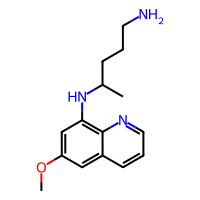
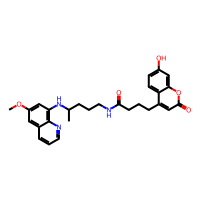
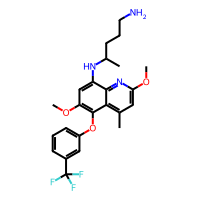
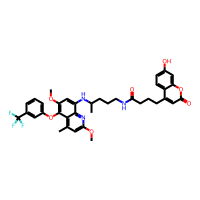

In [57]:
#Calculate the T_coefficients using pq fingerprints as a reference
coeff = []
    
for val in df_['Morgan_fp']:
    value = DataStructs.FingerprintSimilarity(df_['Morgan_fp'][0], val, metric=DataStructs.TanimotoSimilarity)
    coeff.append(value)
        
df_['Tanimoto_Morgan_PQref'] = coeff
df_.head()  

RDKit has other methods for calculating similarity scores such as Dice and Cosine. RDKit can calculate these coefficients by changing the value of the 'metric' parameter in DataStructs.FingerprintSimilarity().

However, similarity scores differ based upon the fingerprints used to generate them. Let's determine the these similarity scores for Morgan, MACCSKey, and Avalon fingerprints, then visualize them for comparisons.

### Dice Similarity

In [58]:
DataStructs.DiceSimilarity(df_['Morgan_fp'][0], df_['Morgan_fp'][2])

0.5904761904761905

,Compound,SMILES,3D7_IC50 (uM),Molecular_structure,Molecular Weight,LogP,Polar Surface Area,H_bond_acc,H_bond_donors,MaxAbsEStateIndex,...,fr_methoxy,fr_phenol,fr_phenol_noOrthoHbond,fr_pyridine,fr_unbrch_alkane,Morgan_fp,MACCS_fp,Avalon_fp,Tanimoto_Morgan_PQref,Dicesim_Morgan_PQref
0,Primaquine,COc2cc(NC(C)CCCN)c1ncccc1c2,5.77,,259.353,2.78270,60.17,4,2,5.546261,...,1,0,0,1,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ...",1.000000,1.000000
1,PQCP,COc4cc(NC(C)CCCNC(=O)CCCc1cc(=O)oc2cc(O)ccc12)...,10.50,,489.572,4.77510,113.69,7,3,12.298928,...,1,1,1,1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, ...",0.493506,0.660870
2,Tafenoquine,COc3cc(C)c2c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)...,3.59,,463.500,5.91082,78.63,6,2,13.195201,...,2,0,0,1,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ...",0.418919,0.590476
3,TQCP,COc5cc(C)c4c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)...,2.19,,693.719,7.90322,132.15,9,3,13.398982,...,2,1,1,1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, ...",0.240741,0.388060

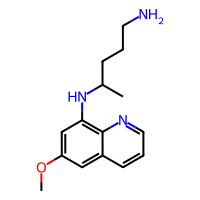
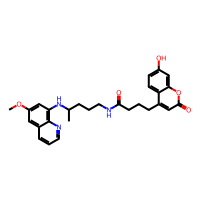
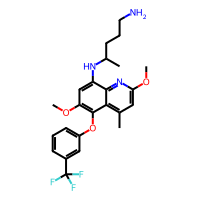
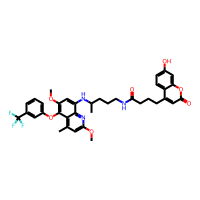

In [59]:
#calculate dice similarity scores for the rest of the morgan fingerprints

Dice = []

for fp in df_['Morgan_fp']:
    dice_score = DataStructs.DiceSimilarity(df_['Morgan_fp'][0], fp)
    Dice.append(dice_score)
    
df_['Dicesim_Morgan_PQref'] = Dice

df_.head()

### Cosine Similarity

In [60]:
DataStructs.CosineSimilarity(df_['Morgan_fp'][0], df_['Morgan_fp'][2])

0.6003874717872365

,Compound,SMILES,3D7_IC50 (uM),Molecular_structure,Molecular Weight,LogP,Polar Surface Area,H_bond_acc,H_bond_donors,MaxAbsEStateIndex,...,fr_phenol,fr_phenol_noOrthoHbond,fr_pyridine,fr_unbrch_alkane,Morgan_fp,MACCS_fp,Avalon_fp,Tanimoto_Morgan_PQref,Dicesim_Morgan_PQref,Cosinesim_Morgan_PQref
0,Primaquine,COc2cc(NC(C)CCCN)c1ncccc1c2,5.77,,259.353,2.78270,60.17,4,2,5.546261,...,0,0,1,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ...",1.000000,1.000000,1.000000
1,PQCP,COc4cc(NC(C)CCCNC(=O)CCCc1cc(=O)oc2cc(O)ccc12)...,10.50,,489.572,4.77510,113.69,7,3,12.298928,...,1,1,1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, ...",0.493506,0.660870,0.682941
2,Tafenoquine,COc3cc(C)c2c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)...,3.59,,463.500,5.91082,78.63,6,2,13.195201,...,0,0,1,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, ...",0.418919,0.590476,0.600387
3,TQCP,COc5cc(C)c4c(Oc1cccc(C(F)(F)F)c1)c(OC)cc(NC(C)...,2.19,,693.719,7.90322,132.15,9,3,13.398982,...,1,1,1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, ...",0.240741,0.388060,0.415641

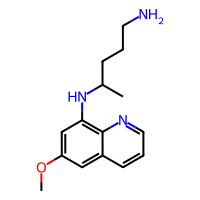
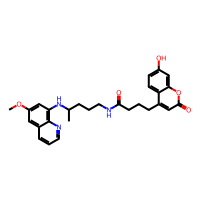
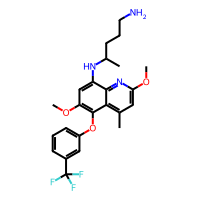
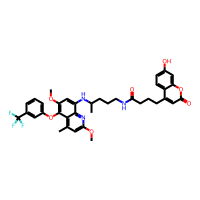

In [61]:
Cosine = []

for value in df_['Morgan_fp']:
    cosine_score = DataStructs.CosineSimilarity(df_['Morgan_fp'][0], value)
    Cosine.append(cosine_score)
    
df_['Cosinesim_Morgan_PQref'] = Cosine
df_.head()

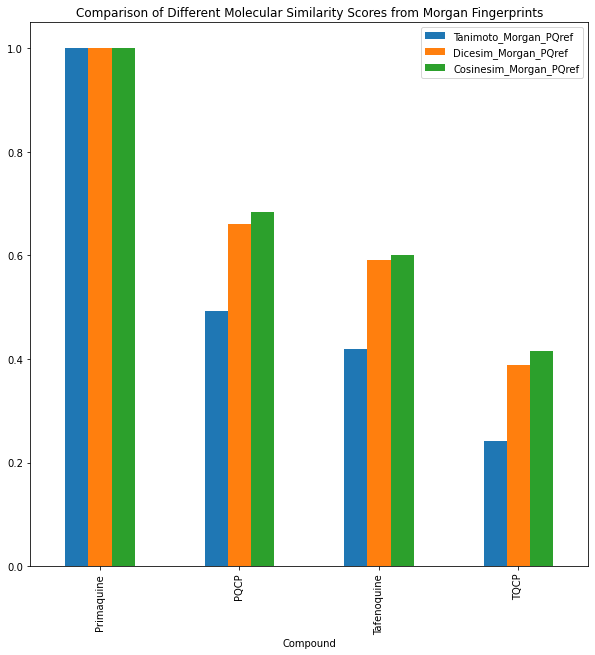

In [62]:
#visualizing the different similarity scores

df_.plot(x='Compound', y=['Tanimoto_Morgan_PQref', 'Dicesim_Morgan_PQref', 'Cosinesim_Morgan_PQref'], kind='bar',
        figsize=(10, 10))
plt.title("Comparison of Different Molecular Similarity Scores from Morgan Fingerprints")
plt.show();


## Similarity Maps for Primaquine and PQCP from Morgan Fingerprints

References to understand Similarity maps via fingerprinting:

> Riniker, S.; Landrum, G. A. “Similarity Maps - A Visualization Strategy for Molecular Fingerprints and Machine-Learning Methods” J. Cheminf. 5:43 (2013)

Here we'll use a function to create a similarity map and calculate weights based on morgan fingerprints. We'll compare the reference and probe compounds to one another to see how the maxweight value changes.

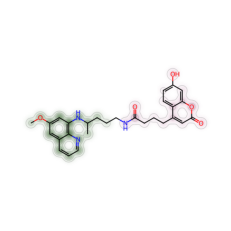

In [63]:
#create a function to draw similarity maps between reference and test molecules

#function for similarity map and maxweight value calculation
def similarity_map(refmol, expmol):
    RDLogger.DisableLog('rdApp.*')  # Disable RDKit logs for this specific task
    
    # Define variable to draw map
    x = Draw.MolDraw2DCairo(500, 500)
    
    # Create figure and maxweight variables to display molecule and calculate maxweight
    # create a lambda function for SimilarityMaps, then select fingerprint type; in this case, we use the Morgan 
    # fingerprint
    #types of Morgan fingerprint: bit vector (bv, default) & count vector (count)
    figure = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, expmol, 
                                                                 lambda d, e: SimilarityMaps.GetMorganFingerprint(d, e, radius=2, 
                                                                                                                  fpType='bv'), 
                                                                 draw2d=x)
    
    # Draw 'x'
    x.FinishDrawing()
    
    # Assign variable to display new similarity map
    image_data = x.GetDrawingText()
    img = Image.open(io.BytesIO(image_data))
    
    # Display image using matplotlib 
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Example usage

similarity_map(PQ, PQCP)


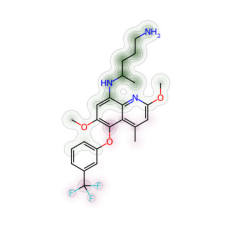

In [64]:
similarity_map(PQ, TQ)

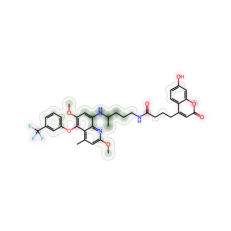

In [65]:
similarity_map(PQ, TQCP)

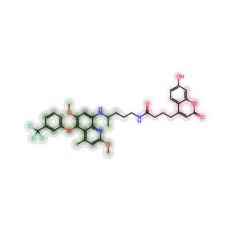

In [66]:
similarity_map(TQ, TQCP)

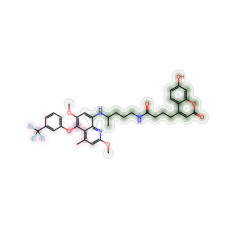

In [67]:
similarity_map(PQCP, TQCP)

## Summary and Conclusions



Here we have generated various molecular fingerprints (Morgan, MACCS, and Avalon), similarity maps, and tanimoto coefficients for 8-AQ probes I synthesized during my Ph.D research. These compounds are near and dear to my heart, as I undertook much labor to create these probes and characterize them for my research. 

The differences in similarity scores are based in 1) how the similarity equations are defined and 2) the fingerprint used to calculate them. Different molecular fingerprints serve different purposes, as indicated in the introduction section.

Malaria, despite all containment and drug discovery efforts, remains a persistent global health challenge that causes the suffering of many people. The highest rates of mortality are for those under the age of 5. With climate change becoming an increasingly difficult problem to deal with, this disease caused by <i>Plasmodium spp</i> parasites has the potential to affect areas where malaria has not been endemic due to increasing temperatures and changing climate patterns. While vaccinations efforts hold promise, therapeutics will always be needed in order to treat the disease until a vaccine is found. 8-AQs, especially Primaquine, are the only class of anti-malarial compounds where resistance has not been observed in nature or in the lab. As such, these molecules and their mechanism of action may hold the key to successful eradication efforts. 

I wish to use this project as a launch point to analyze much larger anti-malarial drug discovery datasets to see what structures are predicted to be most efficacious, and see how 8-AQs stand up. 